In [1]:
from encodingUtils import encode, PlaceCellEncoder2D
theta0=90

sigma_res_noise = 0.005
sigma_S = 0.002

spatial_res = 5

gamma_pg=0.5

gradient_spectral_rad = .8

description='rho=' + str(gradient_spectral_rad) + '_5'

grid_size = spatial_res  
sigma = 0.2 

encoder = PlaceCellEncoder2D(grid_size, sigma)

In [2]:
from envAgent import Environment, LinearAgent
import numpy as np

# BUG: Agent in the environment was not designed to be called
# as any other variable BUT agent, this caused problems (maybe) with agent_res
env = Environment()
agent = LinearAgent()

agent.weights_0 = np.copy(agent.weights)

In [3]:
from goal_onr import RESERVOIRE_SIMPLE_NL_MULT

# Changed time from 600 to 1200
N, I, O, TIME = 2000, 15, 7, 30
shape = (N, I, O, TIME)

dt = 1.0/ TIME 
tau_m_f = 20. * dt
tau_m_s = 20. * dt
tau_s = 2. * dt
tau_ro = .001 * dt
beta_s  = np.exp (-dt / tau_s)
beta_ro = np.exp (-dt / tau_ro)
sigma_teach = 0.
sigma_input = .06
sigma_rec = 0.5/np.sqrt(N)
offT = 1
dv = 5.
alpha_rout = .0005 
alpha_pg = 0.0005
alpha = 0.
Vo = 0
h = 0
s_inh = 0
sigma_output = .1

n_electrodes = 85
n_pca = n_electrodes

par = {'tau_m_f' : tau_m_f,'tau_m_s' : tau_m_s, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'beta_ro' : beta_ro,
    'dv' : dv, 'alpha' : alpha, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
    'N' : N, 'T' : TIME, 'dt' : dt, 'offT' : offT, 'alpha_rout' : alpha_rout,
    'sigma_input' : sigma_input, 'sigma_teach' : sigma_teach,'sigma_rec' : sigma_rec, 'shape' : shape,'sigma_output':sigma_output}

N = 800
# Change to 1 if you want to use the 1 - strategy
gamma_grad = 1.5
input_dim = spatial_res**2 + 4 + 10
shape = ( N , input_dim , 4*spatial_res**2 , TIME )
par['shape']=shape
par['sigma_input'] = sigma_input
par['sigma_rec'] = gradient_spectral_rad/np.sqrt(N)
#par['tau_m_s'] = .00*dt
# par['tau_m_f'] = .00*dt
network_reservoire_gradient = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire_gradient.Jin_mult = np.random.normal(0,0.1,size=(N,))

In [4]:
ERRORS = []

alpha_w = 0.05

r_traj = []
e_traj = []
dw_traj = []
r_targ = []
y_data = []
S = []

x_net_coll = []
y_coll = []

x_grad_net_coll = []
y_grad_coll = []

x_w_coll = []
y_w_coll = []

In [5]:
from tqdm import tqdm

change_every = 600
n_resets = 24

eta = 0.008 * 0.125

dw_filt = 0
n_angle = 0

total_rewards = []
total_reservoire_rates = []
total_gradients = []

for n in tqdm(range(n_resets), desc='Resets', total=n_resets):
    theta0 = 45 * n_angle
    n_angle += 1 

    env.reset(.5,.5, theta0=theta0)
    agent.weights = np.copy(agent.weights_0 * 0)

    rewards = []
    reservoire_rates = []
    gradients = []

    for episode in range(change_every):
        done = False 
        time = 0

        env.reset_inner()
        network_reservoire_gradient.reset()
        agent.update_filt = np.copy(agent.weights_0 * 0)

        reservoire_rate = []
        gradient = []
        
        while not done:
            time += 1
            if time >= TIME:
                break
            
            state = np.copy(env.agent_position)
            state_enc = encoder.encode_position(state)
            logits = agent.weights @ state_enc
            action_probs = np.exp(logits) / np.sum(np.exp(logits))
            action = np.random.choice(len(action_probs), p=action_probs)

            reward, done = env.step(action)
            weights_old = np.copy(agent.weights)
            probs = np.copy(action_probs)
            probs[action] -= 1
            agent.update_filt = agent.update_filt*gamma_pg + (1.-gamma_pg)* np.outer(probs,state_enc)
            dw_out = np.copy(-reward * agent.learning_rate * agent.update_filt) * eta
            agent.weights += dw_out

            r_encoded = encode(reward)

            input_modulation = .1 + gamma_grad * network_reservoire_gradient.Jin_mult * reward
            input_modulation = input_modulation.flatten()

            reservoire_input = np.concatenate((state_enc, probs, r_encoded.flatten()))
            network_reservoire_gradient.step_rate(reservoire_input, input_modulation, 0)

            reservoire_rate.append(network_reservoire_gradient.S)
            gradient.append(dw_out.flatten())

        flat_shape = dw_out.flatten().shape
        # When the episode ends prematurely, pad the reservoire_rate and gradient lists
        if len(gradient) < TIME:
            pad_vec = np.zeros(flat_shape)
            gradient += [pad_vec] * (TIME - len(gradient))
            reservoire_rate += [np.zeros(N)] * (TIME - len(reservoire_rate))

        reservoire_rates.append(reservoire_rate)
        gradients.append(gradient)
        rewards.append(reward)  

    total_reservoire_rates.append(reservoire_rates)
    total_gradients.append(gradients)
    total_rewards.append(rewards)      
        
total_rewards = np.array(total_rewards)
total_reservoire_rates = np.array(total_reservoire_rates)
total_gradients = np.array(total_gradients)

print(total_rewards.shape)
print(total_reservoire_rates.shape)
print(total_gradients.shape)

Resets: 100%|██████████| 24/24 [02:48<00:00,  7.03s/it]


(24, 600)
(24, 600, 30, 800)
(24, 600, 30, 100)


In [6]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
zero_mask        = (total_gradients == 0)          # Boolean array, same shape
n_zeros_global   = zero_mask.sum()                 # absolute count of zeros
frac_zeros_global = n_zeros_global / total_gradients.size
print(f"Overall fraction of zero grads: {frac_zeros_global:.3%}")

Overall fraction of zero grads: 81.119%


Overall fraction of zero gradients: 81.119%


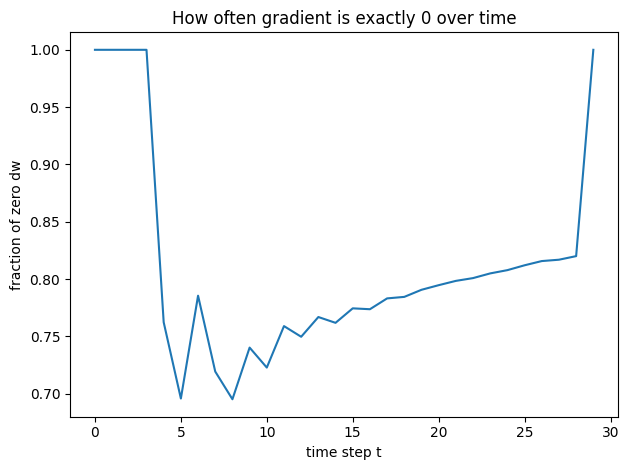

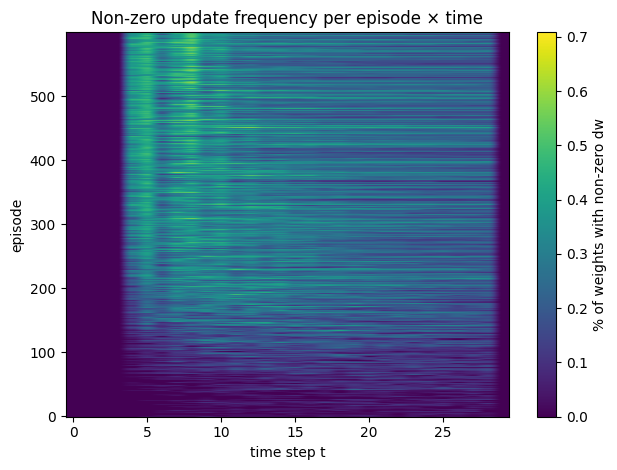

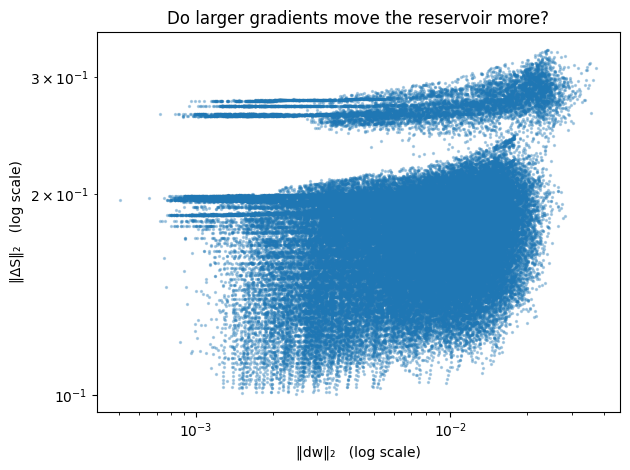

log–log Pearson r = 0.115  (p = 1.28e-238)


In [8]:
"""
ONE-STOP ANALYSIS CELL
──────────────────────
Drop this into a new Jupyter / Colab cell after you have
`total_gradients`, `total_reservoire_rates`, `TIME`, and `N` in memory.
It prints basic stats and draws three quick diagnostic plots:

  1. Fraction of zero gradients over time.
  2. Heat-map (episode × time) of how often *any* weight updated.
  3. Log-log scatter of gradient-norm vs. Δ-reservoir-activity,
     plus a Pearson correlation on the same log–log data.

If SciPy isn’t installed, comment out the Pearson-r lines.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  # comment this if SciPy unavailable

# ------------------------------------------------------------
# 1.  How many gradients are exactly zero?
# ------------------------------------------------------------
zero_mask            = (total_gradients == 0)                     # bool, same shape
n_zeros_global       = zero_mask.sum()
frac_zeros_global    = n_zeros_global / total_gradients.size
print(f"Overall fraction of zero gradients: {frac_zeros_global:.3%}")

# Per weight dimension
frac_zero_per_weight = zero_mask.mean(axis=(0, 1, 2))            # (n_weights,)

# Per time step (averaged over resets & episodes)
frac_zero_per_t      = zero_mask.mean(axis=(0, 1, 3))            # (TIME,)

# ------------------------------------------------------------
# 2.  Visualise where zeros happen
# ------------------------------------------------------------
plt.figure()
plt.plot(frac_zero_per_t)
plt.xlabel("time step t")
plt.ylabel("fraction of zero dw")
plt.title("How often gradient is exactly 0 over time")
plt.tight_layout()
plt.show()

# Heat-map of update frequency  (episode × time)
upd_steps = (~zero_mask).any(axis=-1).mean(axis=0)               # (change_every, TIME)
plt.figure()
plt.imshow(upd_steps, aspect='auto', origin='lower')
plt.colorbar(label='% of weights with non-zero dw')
plt.xlabel('time step t')
plt.ylabel('episode')
plt.title('Non-zero update frequency per episode × time')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3.  Relate gradient size to change in reservoir activity
# ------------------------------------------------------------
grad_norm = np.linalg.norm(total_gradients, axis=-1)             # (..., TIME)
S         = total_reservoire_rates
deltaS    = np.linalg.norm(np.diff(S, axis=2), axis=-1)          # (..., TIME-1)

# Align shapes (skip t=0 for grad_norm)
x = grad_norm[..., 1:].flatten()
y = deltaS.flatten()
nonzero = x > 0

plt.figure()
plt.scatter(x[nonzero], y[nonzero], s=2, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("‖dw‖₂   (log scale)")
plt.ylabel("‖ΔS‖₂   (log scale)")
plt.title("Do larger gradients move the reservoir more?")
plt.tight_layout()
plt.show()

# Correlation on log–log data (optional)
lx, ly = np.log10(x[nonzero]), np.log10(y[nonzero])
r, p   = stats.pearsonr(lx, ly)
print(f"log–log Pearson r = {r:.3f}  (p = {p:.2e})")


C:\Users\marcu\AppData\Local\Temp\ipykernel_17536\201535438.py:14: RuntimeWarning: invalid value encountered in scalar divide
  avg_rewards_interest_reset = (avg_rewards_interest_reset - np.min(avg_rewards_interest_reset)) / (np.max(avg_rewards_interest_reset) - np.min(avg_rewards_interest_reset)) * 10


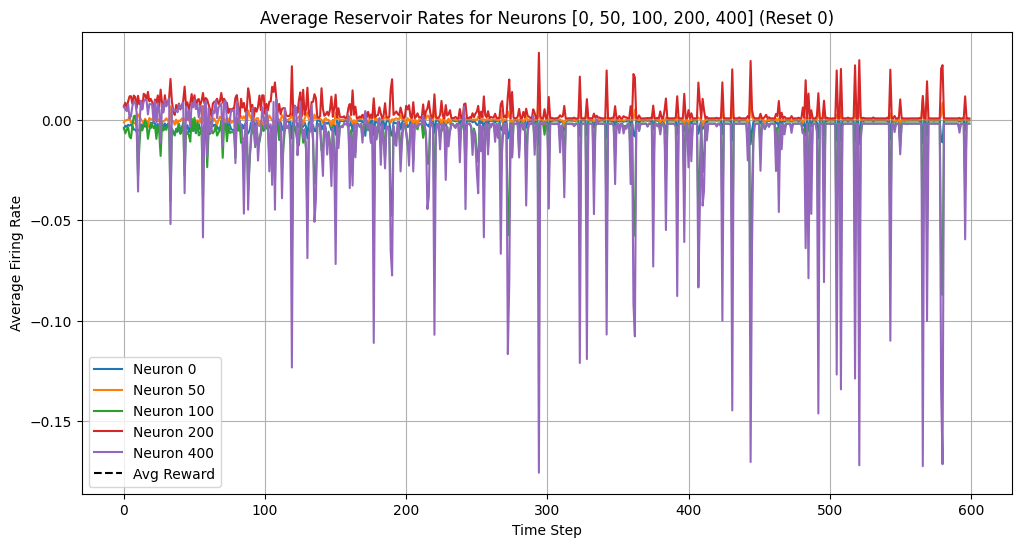

In [9]:
# Pick one reset
interest_reset = 0  
# Now plot for neurons 0, 50, 100, 200, 400 they're average activity across the episodes, so the activity is avergaed across the episodes. 
neurons_of_interest = [0, 50, 100, 200, 400]
# Average the reservoire rates across the episodes for the reset of interest. What I mean is, in a whole episode you should take thse average, so at the end I don't want 30 points, but 600
avg_rates_interest_reset = np.mean(total_reservoire_rates[interest_reset], axis=1)
# Plot the average activity of the neurons of interest
plt.figure(figsize=(12, 6))
for neuron in neurons_of_interest:
    plt.plot(avg_rates_interest_reset[:, neuron], label=f'Neuron {neuron}')
# On top of it plot the avg reward for that episode
avg_rewards_interest_reset = np.mean(total_rewards[interest_reset], axis=0)
# MAp the avg rewards to the 0-0.2 range
avg_rewards_interest_reset = (avg_rewards_interest_reset - np.min(avg_rewards_interest_reset)) / (np.max(avg_rewards_interest_reset) - np.min(avg_rewards_interest_reset)) * 10
plt.plot(avg_rewards_interest_reset, label='Avg Reward', linestyle='--', color='black')

plt.title(f'Average Reservoir Rates for Neurons {neurons_of_interest} (Reset {interest_reset})')
plt.xlabel('Time Step')
plt.ylabel('Average Firing Rate')
plt.legend()
plt.grid()
plt.show()

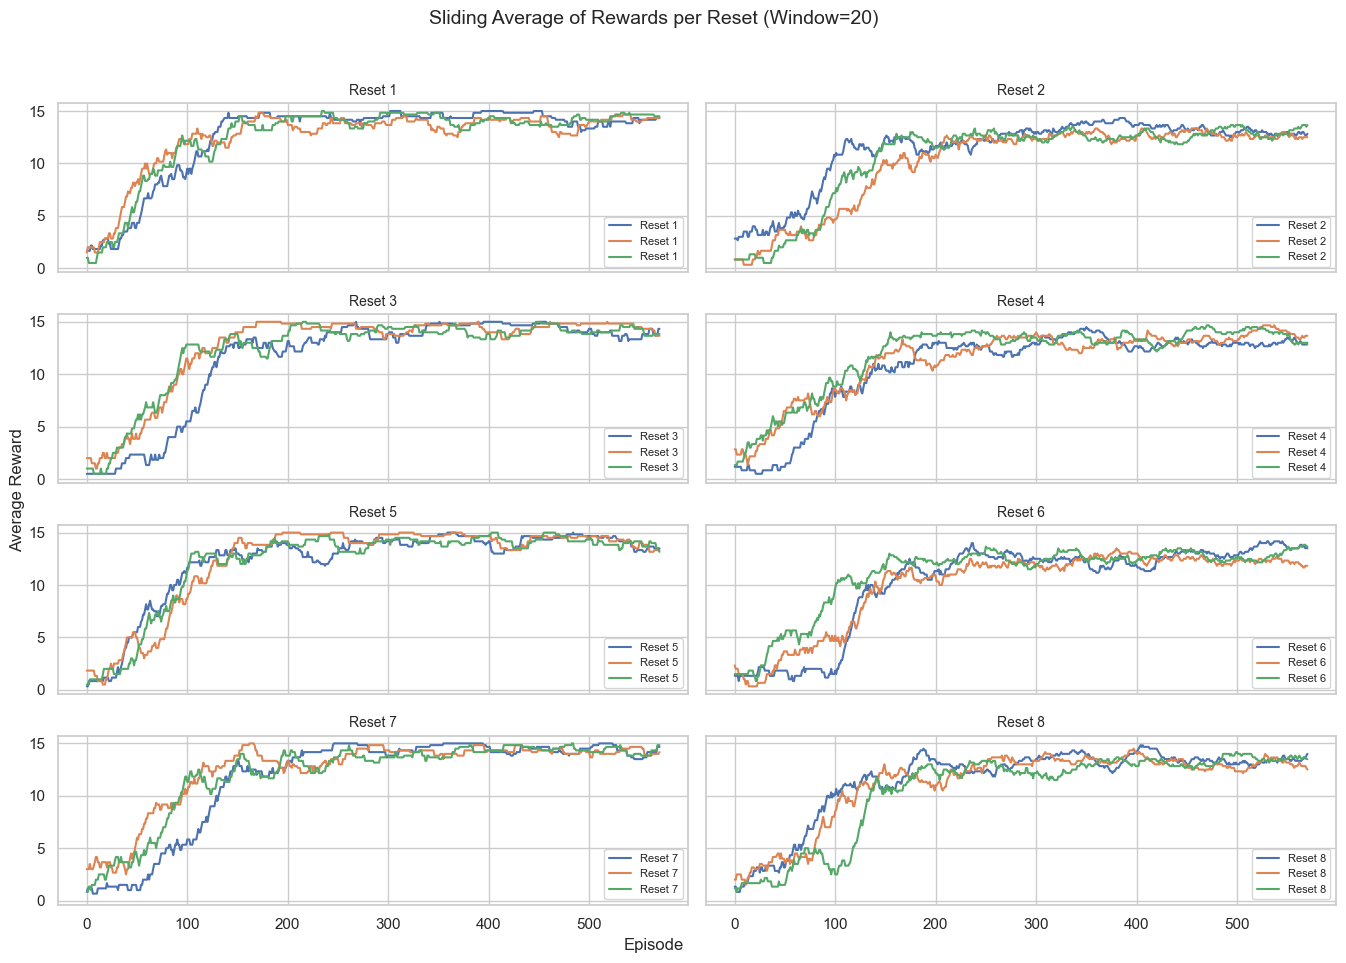

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use seaborn style
sns.set(style="whitegrid")

# Assuming total_rewards is a list of 8 lists, each with episode rewards
fig, ax = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=True)
ax = ax.flatten()

window = 30  # sliding average window size

for i, reward in enumerate(total_rewards):
    i = i % 8  
    reward = np.array(reward)
    # Compute sliding average
    if len(reward) >= window:
        reward_avg = np.convolve(reward, np.ones(window) / window, mode='valid')
    else:
        reward_avg = reward  # too short for convolution

    ax[i].plot(reward_avg, label=f'Reset {i+1}')
    ax[i].set_title(f'Reset {i+1}', fontsize=10)
    ax[i].legend(loc='lower right', fontsize=8)

# Common labels
fig.suptitle("Sliding Average of Rewards per Reset (Window=20)", fontsize=14)
fig.text(0.5, 0.04, 'Episode', ha='center')
fig.text(0.04, 0.5, 'Average Reward', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


In [11]:
# Hyperparams
damping = 1e-8       # replaces your noise_size
batch_size = 1000    # process 1000 steps at a time

# Initialize - using correct reservoir size
N_reservoir = total_reservoire_rates.shape[-1]  # Get actual reservoir size
N_gradient = total_gradients.shape[-1]          # Get actual gradient size

A = damping * np.eye(N_reservoir)  # (N_reservoir, N_reservoir)
B = np.zeros((N_reservoir, N_gradient))   # (N_reservoir, N_gradient)

for reset in range(n_resets):
    counter = 0
    for ep in range(0, 600, batch_size // 30):  # dynamic batching
        # Extract batch (30 steps × N episodes)
        X_batch = total_reservoire_rates[reset, ep:ep+batch_size//30].reshape(-1, N_reservoir)
        Y_batch = total_gradients[reset, ep:ep+batch_size//30].reshape(-1, N_gradient)
        
        # Apply arctanh to gradients (clamp to avoid infinity)
        Y_batch = np.arctanh(np.clip(Y_batch, -0.999, 0.999))
        
        # Update covariance matrices (BLAS-3 optimized)
        A += X_batch.T @ X_batch  # (N_reservoir, N_reservoir)
        B += X_batch.T @ Y_batch  # (N_reservoir, N_gradient)
        
W_out = np.linalg.solve(A, B)
network_reservoire_gradient.Jout = W_out.T

In [12]:
from tqdm import tqdm

change_every = 600
n_resets = 16

eta = 0.008 * 0.125

dw_filt = 0
n_angle = 0

total_rewards_res = []

for n in tqdm(range(n_resets), desc='Resets', total=n_resets):
    theta0= 45/2 * n_angle
    n_angle += 1 

    env.reset(.5,.5, theta0=theta0)
    agent.weights = np.copy(agent.weights_0 * 0)

    rewards = []
    reservoire_rates = []
    gradients = []

    for episode in range(change_every):
        done = False 
        time = 0

        env.reset_inner()
        network_reservoire_gradient.reset()
        agent.update_filt = np.copy(agent.weights_0 * 0)

        reservoire_rate = []
        gradient = []
        
        while not done:
            time += 1
            if time >= TIME:
                break
            
            state = np.copy(env.agent_position)
            state_enc = encoder.encode_position(state)
            logits = agent.weights @ state_enc
            action_probs = np.exp(logits) / np.sum(np.exp(logits))
            action = np.random.choice(len(action_probs), p=action_probs)

            reward, done = env.step(action)
            weights_old = np.copy(agent.weights)
            probs = np.copy(action_probs)
            probs[action] -= 1

            r_encoded = encode(reward)

            input_modulation = .1 + gamma_grad * network_reservoire_gradient.Jin_mult * reward
            input_modulation = input_modulation.flatten()

            reservoire_input = np.concatenate((state_enc, probs, r_encoded.flatten()))
            network_reservoire_gradient.step_rate(reservoire_input, input_modulation, 0)

            dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,spatial_res**2)))
            agent.weights += dw_out

        flat_shape = dw_out.flatten().shape
        # When the episode ends prematurely, pad the reservoire_rate and gradient lists
        if len(gradient) < TIME:
            pad_vec = np.zeros(flat_shape)
            gradient += [pad_vec] * (TIME - len(gradient))
            reservoire_rate += [np.zeros(N)] * (TIME - len(reservoire_rate))

        rewards.append(reward)  

    total_rewards_res.append(rewards)      
        
total_rewards_res = np.array(total_rewards_res)
print(total_rewards_res.shape)

Resets: 100%|██████████| 16/16 [01:42<00:00,  6.38s/it]

(16, 600)


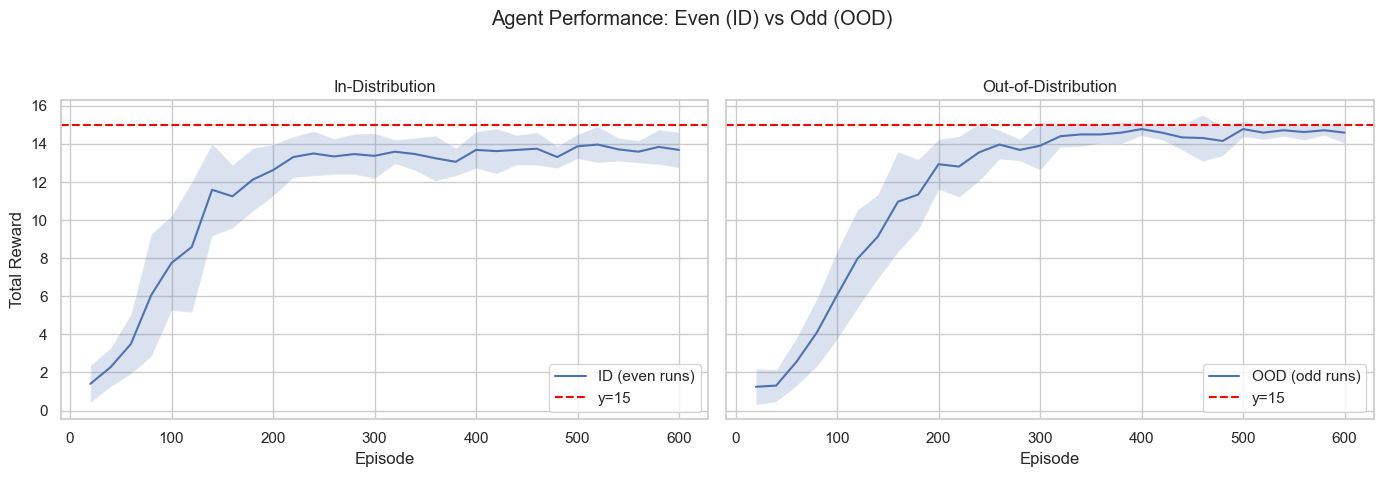

In [13]:
bin_size = 20  
hline    = 15 

indices     = np.arange(total_rewards_res.shape[0])
id_indices  = indices[indices % 2 == 0]  # 0,2,4,...
ood_indices = indices[indices % 2 == 1]  # 1,3,5,...

id_runs  = total_rewards_res[id_indices]   # shape (8, 600)
ood_runs = total_rewards_res[ood_indices]  # shape (8, 600)

def agg(r):
    # r: (runs, episodes)
    bins = r.shape[1] // bin_size
    binned = (
        r[:, : bins * bin_size]
        .reshape(r.shape[0], bins, bin_size)
        .mean(axis=2)  # (runs, bins)
    )
    return binned.mean(axis=0), binned.std(axis=0), np.arange(1, bins + 1) * bin_size

id_mean, id_std, x = agg(id_runs)
ood_mean, ood_std, _ = agg(ood_runs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# In-Distribution (even runs)
axes[0].plot(x, id_mean, label="ID (even runs)")
axes[0].fill_between(x, id_mean - id_std, id_mean + id_std, alpha=0.2)
axes[0].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[0].set_title("In-Distribution")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Total Reward")
axes[0].grid(True)
axes[0].legend()

# Out-of-Distribution (odd runs)
axes[1].plot(x, ood_mean, label="OOD (odd runs)")
axes[1].fill_between(x, ood_mean - ood_std, ood_mean + ood_std, alpha=0.2)
axes[1].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[1].set_title("Out-of-Distribution")
axes[1].set_xlabel("Episode")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Agent Performance: Even (ID) vs Odd (OOD)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
import numpy as np

# Get actual dimensions from your data
N_reservoir = total_reservoire_rates.shape[-1]  # Get actual reservoir size (800)
N_gradient = total_gradients.shape[-1]          # Get actual gradient size (100)

damping = 1e-6       # replaces your noise_size

# Initialize accumulators with correct dimensions
A = damping * np.eye(N_reservoir)  # (N_reservoir, N_reservoir)
B = np.zeros((N_reservoir, N_gradient))   # (N_reservoir, N_gradient)

for reset in range(24):
    for ep in range(600):
        # Extract one episode (30 steps)
        X_ep = total_reservoire_rates[reset, ep]  # (30, N_reservoir)
        Y_ep = total_gradients[reset, ep]         # (30, N_gradient)

        # Convert to arrays if not already
        X_ep = np.array(X_ep)
        Y_ep = np.array(Y_ep)

        # Find the last index with a non-zero gradient vector (assumed padding at end)
        last_valid_index = -1
        for i in reversed(range(len(Y_ep))):
            if not np.all(Y_ep[i] == 0):
                last_valid_index = i
                break
        
        if last_valid_index == -1:
            continue  # Skip this episode if it's all padding

        X_trimmed = X_ep[:last_valid_index + 1]  # (N, N_reservoir)
        Y_trimmed = Y_ep[:last_valid_index + 1]  # (N, N_gradient)

        
        grad_sum = np.sum(np.arctanh(Y_trimmed), axis=0) * 10 # 4     # (N_gradient,)
        last_rate = X_trimmed[-1]                 # (N_reservoir,)

        A += np.outer(last_rate, last_rate)       # (N_reservoir, N_reservoir)
        B += np.outer(last_rate, grad_sum)        # (N_reservoir, N_gradient)

W_out = np.linalg.solve(A, B)  # (N_reservoir, N_gradient)
network_reservoire_gradient.Jout = W_out.T       # (N_gradient, N_reservoir)

In [17]:
from tqdm import tqdm

# Now let's perform a one shot training, here we search for the food, and then we update just once, and we see how it goes

change_every = 600
n_resets = 32

dw_filt = 0
n_angle = 0

total_rewards_res = []

for n in tqdm(range(n_resets), desc='Resets', total=n_resets):
    theta0= 45/2 * n_angle
    n_angle += 1 

    env.reset(.5,.5, theta0=theta0)
    agent.weights = np.copy(agent.weights_0 * 0)

    rewards = []
    reservoire_rates = []
    gradients = []

    for episode in range(change_every):
        done = False 
        time = 0

        env.reset_inner()
        network_reservoire_gradient.reset()
        agent.update_filt = np.copy(agent.weights_0 * 0)

        reservoire_rate = []
        gradient = []
        
        while not done:
            time += 1
            if time >= TIME:
                break
            
            state = np.copy(env.agent_position)
            state_enc = encoder.encode_position(state)
            logits = agent.weights @ state_enc
            action_probs = np.exp(logits) / np.sum(np.exp(logits))
            action = np.random.choice(len(action_probs), p=action_probs)

            reward, done = env.step(action)
            weights_old = np.copy(agent.weights)
            probs = np.copy(action_probs)
            probs[action] -= 1

            r_encoded = encode(reward)

            input_modulation = .1 + gamma_grad * network_reservoire_gradient.Jin_mult * reward
            input_modulation = input_modulation.flatten()

            reservoire_input = np.concatenate((state_enc, probs, r_encoded.flatten()))
            network_reservoire_gradient.step_rate(reservoire_input, input_modulation, 0)

            if done:
                agent.weights += np.copy(np.reshape(network_reservoire_gradient.y,(4,spatial_res**2)))
                
        rewards.append(reward)  

    total_rewards_res.append(rewards)      
        
total_rewards_res = np.array(total_rewards_res)
print(total_rewards_res.shape)

Resets:   0%|          | 0/32 [00:00<?, ?it/s]

Resets: 100%|██████████| 32/32 [02:09<00:00,  4.05s/it]

(32, 600)


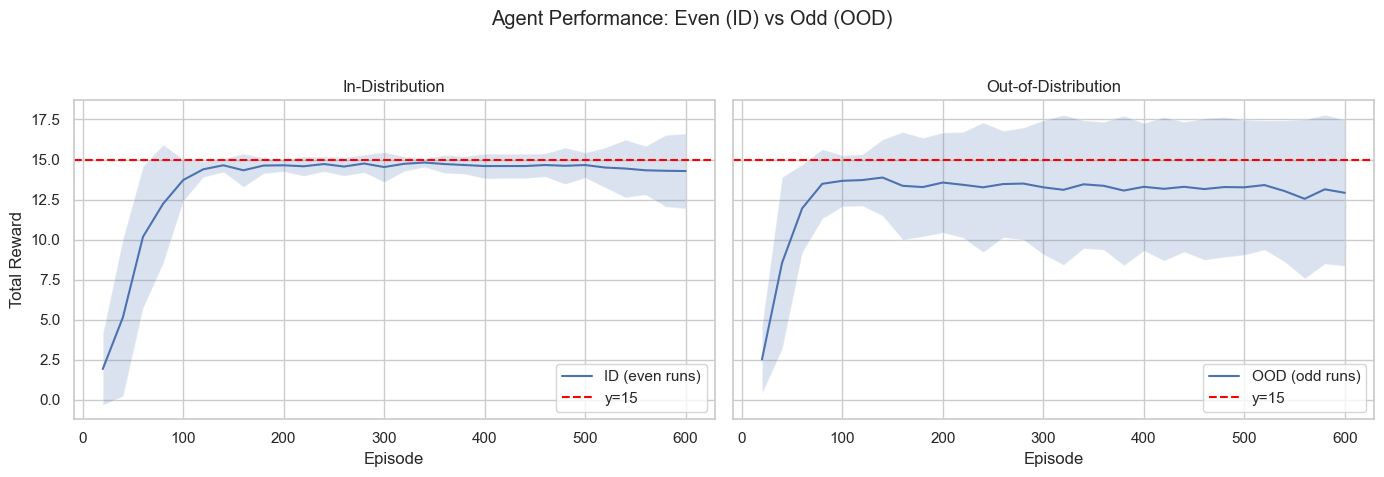

In [18]:
bin_size = 20  
hline    = 15 

indices     = np.arange(total_rewards_res.shape[0])
id_indices  = indices[indices % 2 == 0]  # 0,2,4,...
ood_indices = indices[indices % 2 == 1]  # 1,3,5,...

id_runs  = total_rewards_res[id_indices]   # shape (8, 600)
ood_runs = total_rewards_res[ood_indices]  # shape (8, 600)

def agg(r):
    # r: (runs, episodes)
    bins = r.shape[1] // bin_size
    binned = (
        r[:, : bins * bin_size]
        .reshape(r.shape[0], bins, bin_size)
        .mean(axis=2)  # (runs, bins)
    )
    return binned.mean(axis=0), binned.std(axis=0), np.arange(1, bins + 1) * bin_size

id_mean, id_std, x = agg(id_runs)
ood_mean, ood_std, _ = agg(ood_runs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# In-Distribution (even runs)
axes[0].plot(x, id_mean, label="ID (even runs)")
axes[0].fill_between(x, id_mean - id_std, id_mean + id_std, alpha=0.2)
axes[0].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[0].set_title("In-Distribution")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Total Reward")
axes[0].grid(True)
axes[0].legend()

# Out-of-Distribution (odd runs)
axes[1].plot(x, ood_mean, label="OOD (odd runs)")
axes[1].fill_between(x, ood_mean - ood_std, ood_mean + ood_std, alpha=0.2)
axes[1].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[1].set_title("Out-of-Distribution")
axes[1].set_xlabel("Episode")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Agent Performance: Even (ID) vs Odd (OOD)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()